# Introduction

This Morglorb recipe uses groupings of ingredients to try to cover nutritional requirements with enough overlap that a single ingredient with quality issues does not cause a failure for the whole recipe. An opimizer is used to find the right amount of each ingredient to fulfill the nutritional and practical requirements.

# To Do

* Nutrients without an upper limit should have the upper limit constraint removed
* Add constraints for the NIH essential protein combinations as a limit
* Add a radar graph for vitamins showing the boundry between RDI and UL
* Add a radar graph for vitamins without an upper limit but showing the RDI
* Add a radar graph for essential proteins showing the range between RDI and UL
* Add a radar graph for essential proteins without an upper limit, but showing the RDI as the lower limit
* Add a radar graph pair for non-essential proteins with the above UL and no UL pairing
* Add equality constraints for at least energy, and macro nutrients if possible

In [2]:
# Import all of the helper libraries 

from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import least_squares, lsq_linear, dual_annealing, minimize
import pandas as pd
import numpy as np
import os
import json
from math import e, log, log10
import matplotlib.pyplot as plt
import seaborn as sns
from ipysheet import from_dataframe, to_dataframe

In [3]:
#!pip install seaborn
#!pip install ipysheet
#!pip install ipywidgets

In [4]:
# Setup the notebook context

data_dir = '../src/data'
pd.set_option('max_columns', 70)

# Our Data

The [tables](https://docs.google.com/spreadsheets/d/104Y7kH4OzmfsM-v2MSEoc7cIgv0aAMT2sQLAmgkx8R8/edit#gid=442191411) containing our ingredients nutrition profile are held in Google Sheets.
The sheet names are "Ingredients" and "Nutrition Profile"

In [5]:
# Download our nutrition profile data from Google Sheets

# For the technique to download the sheet data, see third post in SO: https://stackoverflow.com/questions/33713084/download-link-for-google-spreadsheets-csv-export-with-multiple-sheets
# The "Ugrainium PB" spreadsheet
ingredient_tab_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR46GO190pKxg8hm80NE5mLc2hDKDLJ7ZCLbIuIvx71gikSCI079pYhnljclZ7ltsr4SF_zuPoXCeso/pub?gid=1812860789&single=true&output=csv'
nutrition_tab_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR46GO190pKxg8hm80NE5mLc2hDKDLJ7ZCLbIuIvx71gikSCI079pYhnljclZ7ltsr4SF_zuPoXCeso/pub?gid=624419712&single=true&output=csv'

nutrition_profile_df = pd.read_csv(nutrition_tab_url, index_col=0, verbose=True)
for col in ['RDI', 'UL', 'Target Scale', 'Target', 'Weight']:
    nutrition_profile_df[col] = nutrition_profile_df[col].astype(float)
nutrition_profile_df = nutrition_profile_df.transpose()

ingredients_df = pd.read_csv(ingredient_tab_url, index_col=0, verbose=True).transpose()

# convert all values to float
for col in ingredients_df.columns:
    ingredients_df[col] = ingredients_df[col].astype(float)
#ingredients_df

Tokenization took: 0.09 ms
Type conversion took: 1.87 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 0.10 ms
Type conversion took: 1.96 ms
Parser memory cleanup took: 0.02 ms


# Problem Setup

Let's cast our data into the from $\vec{y} = A \vec{x} + \vec{b}$ where $A$ is our ingredients data, $\vec{x}$ is the quantity of each ingredient for our recipe, and $\vec{b}$ is the nutrition profile.
The problem to be solved is to find the quantity of each ingredient which will optimally satisfy the nutrition profile, or in our model, to minimize: $|A \vec{x} - \vec{b}|$.

There are some nutrients we only want to track, but not optimize. For example, we want to know how much cholesterol is contained in our recipe, but we don't want to constrain our result to obtain a specific amount of cholesterol as a goal. The full list of ingredients are named: A_full, and b_full. The values to optimized are named: A and b

In [6]:
ingredients_df.shape, nutrition_profile_df.shape

((17, 61), (8, 61))

In [7]:
b_full = nutrition_profile_df
A_full = ingredients_df.transpose()
A = ingredients_df.transpose()[nutrition_profile_df.loc['Report Only'] == False].astype(float)

b_full = nutrition_profile_df.loc['Target']
b = nutrition_profile_df.loc['Target'][nutrition_profile_df.loc['Report Only'] == False].astype(float)
ul = nutrition_profile_df.loc['UL'][nutrition_profile_df.loc['Report Only'] == False].astype(float)
rdi = nutrition_profile_df.loc['RDI'][nutrition_profile_df.loc['Report Only'] == False].astype(float)
weight = nutrition_profile_df.loc['Weight'][nutrition_profile_df.loc['Report Only'] == False]
ul_full = nutrition_profile_df.loc['UL']
rdi_full = nutrition_profile_df.loc['RDI']
A_full.shape

(61, 17)

In [15]:
# Constrain ingredients before the optimization process. Many of the ingredients are required for non-nutritional purposes 
# or are being limited to enhance flavor
#
# The bounds units are in fractions of 100g / day, i.e.: 0.5 represents 50g / day, of the ingredient

#bounds_df = pd.DataFrame(index=ingredients_df.index, data={'lower': 0.0, 'upper': np.inf})
bounds_df = pd.DataFrame(index=ingredients_df.index, data={'lower': 0.0, 'upper': 1.0e6})
bounds_df.loc['Guar gum'] = [1.0 * .01, 1.0 * .01 + .0001]
bounds_df.loc['Xanthan Gum'] = [1.0 * .01, 1.0 * .01 + .0001]
#bounds_df.loc['Alpha-galactosidase enzyme (Beano)'] = [1.0, 1.0 + .0001]
bounds_df.loc['Multivitamin'] = [1.0, 1.0 + .0001]
#bounds_df.loc['Corn flour, nixtamalized'] = [0, 1.0]
bounds_df.loc['Whey protein'] = [0.0,0.15]
bounds_df.loc['Ascorbic acid'] = [0.01, 0.01 + .0001]
#bounds_df.loc['Peanut butter'] = [0.70, 5.0]
bounds_df.loc['Wheat bran, crude'] = [0.25, 5.0]
bounds_df.loc['Flaxseed, fresh ground'] = [0.25, 5.0]
bounds_df.loc['Choline Bitartrate'] = [0.0, 0.05]
bounds_df.loc['Potassium chloride'] = [0.0, 0.15]
bounds_df.loc['Canola oil'] = [0.01, 5.0]  # Minimum amount set to allow mixing of gums, dry pills, and lecithin 
lower = bounds_df.lower.values
upper = bounds_df.upper.values
lower.shape, upper.shape
x0 = pd.array(lower)
bounds = pd.DataFrame( data = {'lower': lower, 'upper': upper}, dtype=float)
bounds.shape

array([0.25, 0.  , 0.25, 0.  , 0.  , 0.  , 0.01, 1.  , 0.01, 0.  , 0.  ,
       0.  , 0.  , 0.01, 0.01, 0.  , 0.  ])

In [9]:
a = 100.; b = 2.; c = a; k = 10
a = 20.; b = 2.; c = a; k = 10
a = 5.; b = 0.1 ; c = a; k = 5
#a = 12.; b = 0.1 ; c = 10.; k = 10.
#u0 = (rdi + np.log(rdi)); u0.name = 'u0'
#u0 = rdi * (1 + log(a))
u0 = rdi / (1 - log(k) / a)
u1 = ul / (log(k) / c + 1)
#u1 = ul - np.log(ul); u1.name = 'u1'

# Some objectives are singular without an upper/lower bound
u1.loc[u0 > u1] = (u0 + u1) / 2.0
#u = pd.concat([limits, pd.Series(y0,scale_limits.index, name='y0')], axis=1)

def obj(x):
    y0 = A.dot(x.transpose())
    obj_vec = (np.exp(a * (u0 - y0)/u0) + np.exp(b * (y0 - u0)/u0) + np.nan_to_num(np.exp(c * (y0 - u1)/u1))) * weight
    #print(f'obj_vec: {obj_vec[0]}, y0: {y0[0]}, u0: {u0[0]}')
    return(np.sum(obj_vec))
  
rdi[26], u0[26], u1[26], ul[26]
rdi[0:5], u0[0:5], u1[0:5], ul[0:5]
#np.log(rdi)[26]
#u1
#rdi[u0 > u1], u0[u0 > u1], u1[u0 > u1], ul[u0 > u1]
u0['Calories (kcal)'], u1['Calories (kcal)']

(2654.4271326000526, 2159.3569456414143)

In [27]:
solution = minimize(obj, x0, method='SLSQP', bounds=list(zip(lower, upper)), options = {'maxiter': 10000, 'disp': True, 'ftol': 0.000001})
solution.success

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1841.0765435762607
            Iterations: 53
            Function evaluations: 999
            Gradient evaluations: 53


True

In [28]:
x0.shape, A.shape, list(zip(lower, upper))
np.exp(0)

1.0

In [29]:
A_full.dot(solution.x).astype(int)

Calories (kcal)         2374
Carbohydrates (g)        335
Protein (g)              118
Total Fat (g)             81
Saturated Fat (g)          9
                       ...  
Glutamic acid (mg)     23207
Glycine (mg)            4511
Proline (mg)            7063
Serine (mg)             6529
Hydroxyproline (mg)      265
Length: 61, dtype: int64

In [30]:
# Scale the ingredient nutrient amounts for the given quantity of each ingredient given by the optimizer
solution_df = A_full.transpose().mul(solution.x, axis=0) # Scale each nutrient vector per ingredient by the amount of the ingredient
solution_df.insert(0, 'Quantity (g)', solution.x * 100) # Scale to 100 g since that is basis for the nutrient quantities

# Add a row showing the sum of the scaled amount of each nutrient
total = solution_df.sum()
total.name = 'Total'
solution_df = solution_df.append(total)

In [31]:
solution_df['Potassium (g)']

Wheat bran, crude          1.409522
Millet Flour               0.690216
Flaxseed, fresh ground     0.636153
Pea Protein Powder         0.000000
Soy protein isolate        0.198796
Whey protein               0.072000
Canola oil                 0.000000
Multivitamin               0.080008
Ascorbic acid              0.000000
Calcium and vitamin D      0.000000
Vitamin K                  0.000000
Salt, iodized              0.000000
Potassium chloride         7.544951
Guar gum                   0.000000
Xanthan Gum                0.003444
Choline Bitartrate         0.000000
Lecithin granules          0.081952
Total                     10.717042
Name: Potassium (g), dtype: float64

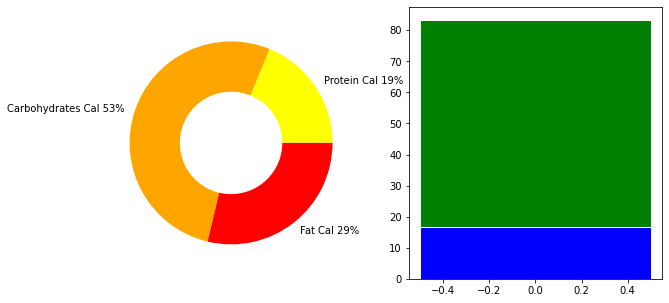

In [32]:
# Plot the macro nutrient profile
# The ratio of Calories for protein:carbohydrates:fat is 4:4:9 kcal/g
pc = solution_df['Protein (g)']['Total'] * 4.0
cc = solution_df['Carbohydrates (g)']['Total'] * 4.0
fc = solution_df['Total Fat (g)']['Total'] * 9.0
tc = pc + cc + fc
p_pct = int(round(pc / tc * 100))
c_pct = int(round(cc / tc * 100))
f_pct = int(round(fc / tc * 100))
(p_pct, c_pct, f_pct)
# create data
names=f'Protein Cal {p_pct}%', f'Carbohydrates Cal {c_pct}%', f'Fat Cal {f_pct}%', 
size=[p_pct, c_pct, f_pct]
 
fig = plt.figure(figsize=(10, 5))

fig.add_subplot(1,2,1)
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.5, color='white')

# Give color names
cmap = plt.get_cmap('Spectral')
sm = plt.cm.ScalarMappable(cmap=cmap)
colors = ['yellow','orange','red']
plt.pie(size, labels=names, colors=colors)

#p=plt.gcf()
#p.gca().add_artist(my_circle)
fig.gca().add_artist(my_circle)
#plt.show()

fig.add_subplot(1,2,2)
barWidth = 1
fs = [solution_df['Soluble Fiber (g)']['Total']]
fi = [solution_df['Insoluble Fiber (g)']['Total']]
plt.bar([0], fs, color='blue', edgecolor='white', width=barWidth, label=['Soluble Fiber (g)'])
plt.bar([0], fi, bottom=fs, color='green', edgecolor='white', width=barWidth, label=['Insoluble Fiber (g)'])
plt.show()
# Also show the Omega-3, Omega-6 ratio
# Saturated:Monounsaturated:Polyunsaturated ratios

In [41]:
# Prepare data as a whole for plotting by normalizing and scaling
amounts = solution_df
total = A_full.dot(solution.x) #solution_df.loc['Total']

# Normalize as a ratio beyond RDI
norm = (total) / rdi_full
norm_ul = (ul_full) / rdi_full

nuts = pd.concat([pd.Series(norm.values, name='value'), pd.Series(norm.index, name='name')], axis=1)
norm['Potassium (g)']


2.280221758482958

In [34]:
# Setup categories of nutrients and a common plotting function
vitamins = ['Vitamin A (IU)','Vitamin B6 (mg)','Vitamin B12 (ug)','Vitamin C (mg)','Vitamin D (IU)',
            'Vitamin E (IU)','Vitamin K (ug)','Thiamin (mg)','Riboflavin (mg)','Niacin (mg)','Folate (ug)','Pantothenic Acid (mg)','Biotin (ug)','Choline (mg)']
minerals = ['Calcium (g)','Chloride (g)','Chromium (ug)','Copper (mg)','Iodine (ug)','Iron (mg)',
            'Magnesium (mg)','Manganese (mg)','Molybdenum (ug)','Phosphorus (g)','Potassium (g)','Selenium (ug)','Sodium (g)','Sulfur (g)','Zinc (mg)']
essential_aminoacids = ['Cystine (mg)','Histidine (mg)','Isoleucine (mg)','Leucine (mg)','Lysine (mg)',
                        'Methionine (mg)','Phenylalanine (mg)','Threonine (mg)','Tryptophan (mg)','Valine (mg)']
other_aminoacids = ['Tyrosine (mg)','Arginine (mg)','Alanine (mg)','Aspartic acid (mg)','Glutamic acid (mg)','Glycine (mg)','Proline (mg)','Serine (mg)','Hydroxyproline (mg)']

def plot_group(nut_names, title):
    nut_names_short = [s.split(' (')[0] for s in nut_names] # Snip off the units from the nutrient names
    
    # Create a bar to indicate an upper limit 
    ul_bar = (norm_ul * 1.04)[nut_names]
    ul_bar[ul_full[nut_names].isnull() == True] = 0
    
    # Create a bar to mask the UL bar so just the end is exposed
    ul_mask = norm_ul[nut_names]
    ul_mask[ul_full[nut_names].isnull() == True] = 0
    
    
    n = []  # normalized values for each bar
    for x, mx in zip(norm[nut_names], ul_mask.values):
        if mx == 0: # no upper limit
            if x < 1.0:
                n.append(1.0 - (x / 2.0))
            else:
                n.append(0.50)
        else:
            n.append(1.0 - (log10(x) / log10(mx)))
    clrs = sm.to_rgba(n, norm=False)
    
    g = sns.barplot(x=ul_bar.values, y=nut_names_short, color='red')
    g.set_xscale('log')
    sns.barplot(x=ul_mask.values, y=nut_names_short, color='white')
    bax = sns.barplot(x=norm[nut_names], y=nut_names_short, label="Total", palette=clrs)
    
    # Add a legend and informative axis label
    g.set( ylabel="",xlabel="Nutrient Mass / RDI (Red Band is UL)", title=title)

    #sns.despine(left=True, bottom=True)

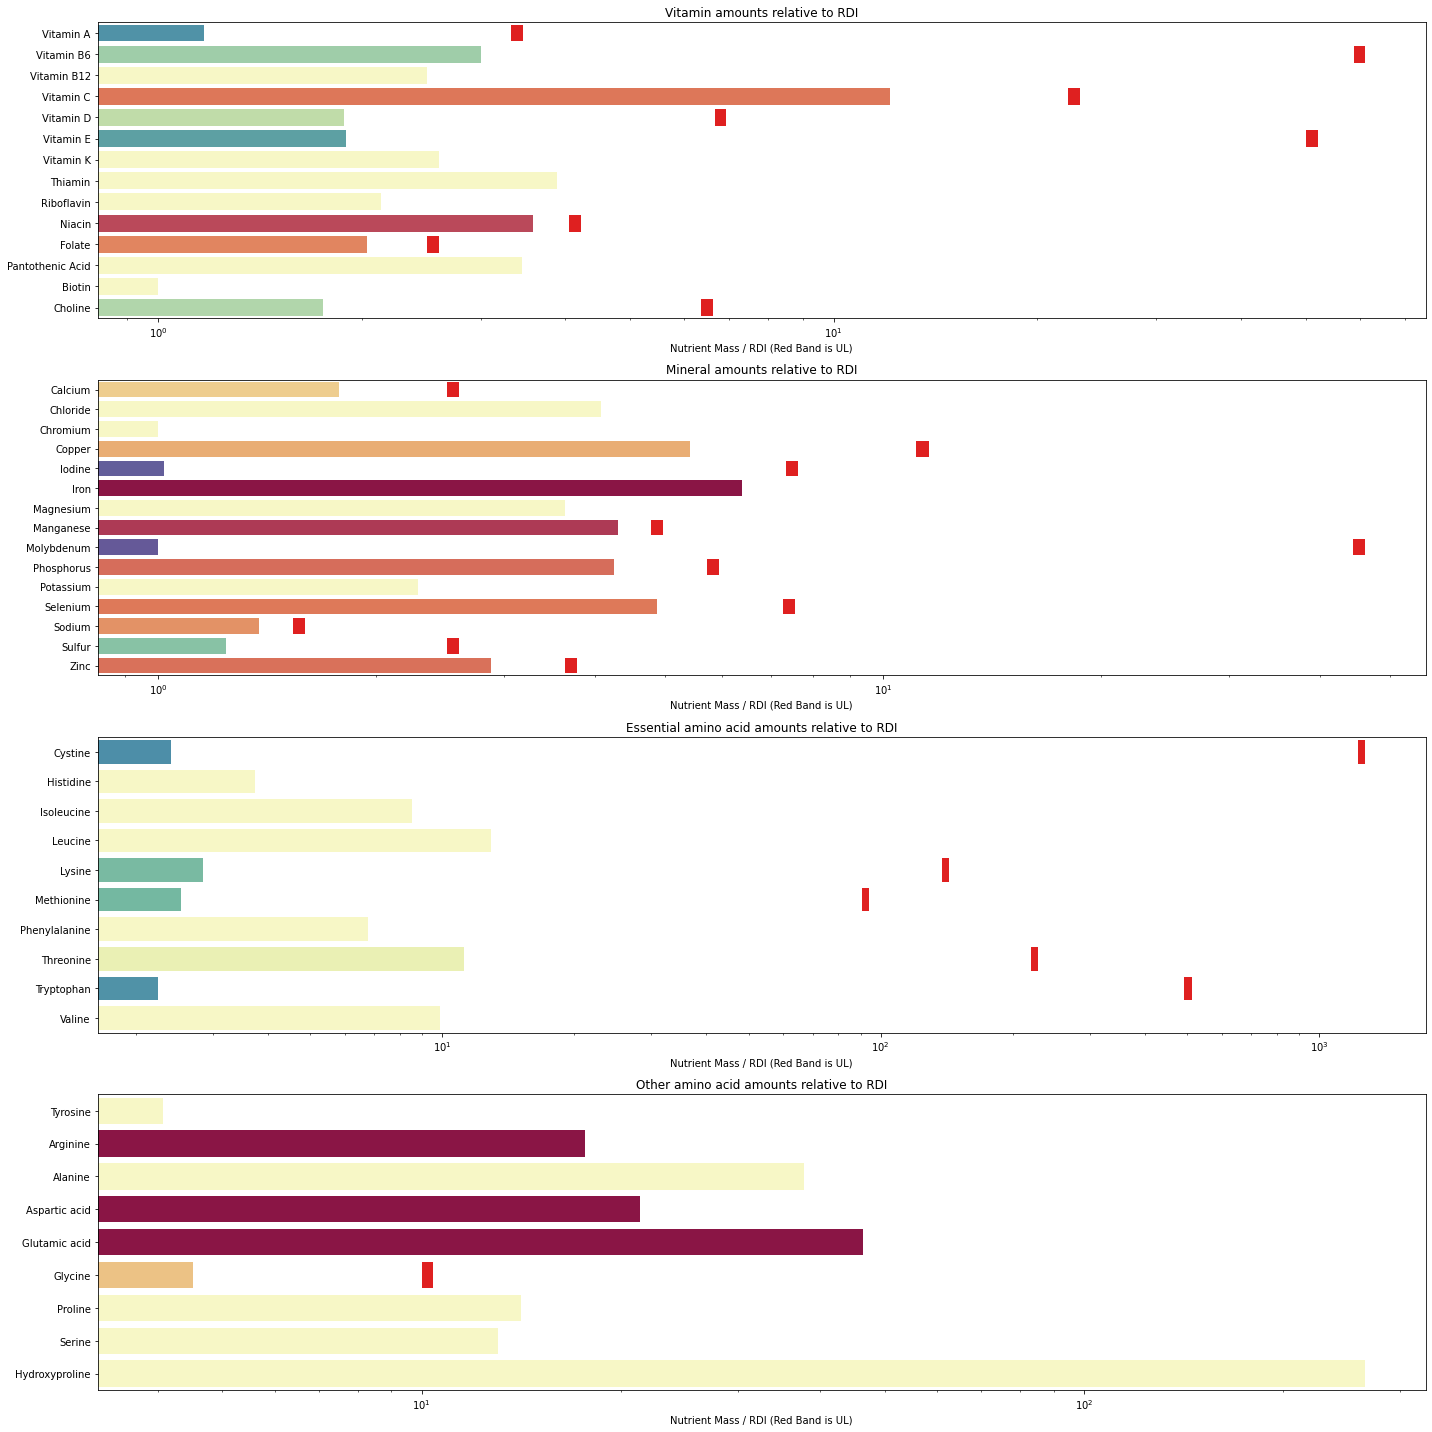

In [35]:
# Construct a group of bar charts for each nutrient group

# Setup the colormap for each bar
cmap = plt.get_cmap('Spectral')
sm = plt.cm.ScalarMappable(cmap=cmap)

#fig = plt.figure(figsize=plt.figaspect(3.))
fig = plt.figure(figsize=(20, 20))
fig.add_subplot(4, 1, 1)
plot_group(vitamins,'Vitamin amounts relative to RDI')
fig.add_subplot(4, 1, 2)
plot_group(minerals,'Mineral amounts relative to RDI')
fig.add_subplot(4, 1, 3)
plot_group(essential_aminoacids,'Essential amino acid amounts relative to RDI')
fig.add_subplot(4, 1, 4)
plot_group(other_aminoacids,'Other amino acid amounts relative to RDI')

#fig.show()
fig.tight_layout()

In [63]:
#solu_amount = (solution_df['Quantity (g)'] * 14).astype(int)
pd.options.display.float_format = "{:,.2f}".format
solu_amount = solution_df['Quantity (g)']
solu_amount.index.name = 'Ingredient'
#solu_amount['Batch (g)'] = solu_amount * 14.0
solu_amount.reset_index()
recipe = pd.DataFrame(solu_amount)
recipe['Batch (g)'] = recipe['Quantity (g)'] * 14.0
recipe

,Quantity (g),Batch (g)
Ingredient,,
"Wheat bran, crude",119.25,"1,669.48"
Millet Flour,308.13,"4,313.85"
"Flaxseed, fresh ground",78.25,"1,095.47"
Pea Protein Powder,30.24,423.42
Soy protein isolate,12.50,175.04
Whey protein,15.00,210.00
Canola oil,30.19,422.64
Multivitamin,100.01,"1,400.14"
Ascorbic acid,1.00,14.00


In [64]:
A_full.dot(solution.x).astype(int)['Calories (kcal)']

2374

In [65]:
recipe['Quantity (g)']['Total']

959.2155232049505

In [66]:
calories = A_full.dot(solution.x).astype(int)['Calories (kcal)']
weight = recipe['Quantity (g)']['Total'] - recipe['Quantity (g)']['Vitamin K'] - recipe['Quantity (g)']['Alpha-galactosidase enzyme (Beano)'] - recipe['Quantity (g)']['Multivitamin'] - recipe['Quantity (g)']['Calcium and vitamin D'] 
cal_by_100g = int(calories / weight * 100.)
'Calories per 100 g:', cal_by_100g

KeyError: 'Alpha-galactosidase enzyme (Beano)'

In [46]:
'Volume of 1/7 of pitcher:', 2000 / 7

('Volume of 1/7 of pitcher:', 285.7142857142857)

In [67]:
meal = pd.DataFrame.from_dict({'Calories (kcal)': range(1000, 2600, 100)})
meal['Measure (g)'] = round(meal['Calories (kcal)'] / cal_by_100g * 100)
print('Amount to measure daily for calorie goal: ')
meal

NameError: name 'cal_by_100g' is not defined